In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
import math
import random
import pickle
from statistics import mode

We declare a function, clean_comment, to regex and tokenize comments.

In [19]:
stop_words = set(stopwords.words("english"))

def clean_comment(comment):
    ps = PorterStemmer()
    regex = re.compile('[^ a-zA-Z]')
    cleaned_comment = regex.sub('', comment)
    tokenized_words = word_tokenize(cleaned_comment.lower())
    cleaned_comments = []

    for word in tokenized_words:
        if word not in stop_words:
            cleaned_comments.append(ps.stem(word))

    return cleaned_comments

We start by creating a df of our sample data. We then have to do some work on it to prep it as training data.

In [20]:
df = pd.read_csv('wallstreetbets-posts-and-comments-for-august-2021-comments.csv', sep=',', encoding='latin-1')
df = df.filter(['body', 'sentiment'])

sentiment = df['sentiment']
actual_sentiment = []
text = df['body']


for i in range(len(sentiment)):
    if sentiment[i] > 0.3:
        actual_sentiment.append(1)
    if sentiment[i] < -0.3:
        actual_sentiment.append(-1)
    else:
        actual_sentiment.append(0)

data_tuples = list(zip(text, actual_sentiment))
df = pd.DataFrame(data_tuples, columns=['Text', 'Sentiment'])
df = df.head(10000)

print(df.head(10))

                                                Text  Sentiment
0                                       What's updog          0
1                                    Donât tell em          0
2  I realize this, ive been losing thousands shoo...          1
3                       then it tanks after earnings          0
4  Are you saying I should or shouldnât yolo my...          0
5  Right?! Youâre here because you trade and tr...          0
6                                       Farmers Only          1
7  Yahoo is a fantastic resource you absolute cretin          0
8             Going to have some Asian Thursday bois          0
9  Are you holding bags?\n\nHope and prayers are ...          1


Let us look into class balance in the above df.

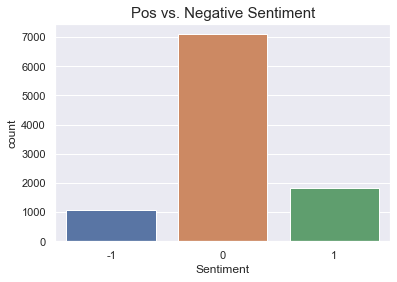

In [21]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

Based on the above, we need to upsample our negative sentiment.

In [22]:
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == -1]

minority_upsample = resample(df_minority, replace = True, n_samples = df_majority.shape[0], random_state=101)

df_upsampled = pd.concat([minority_upsample, df_majority])
df_upsampled = df_upsampled.sample(frac=1)

Check our upsample

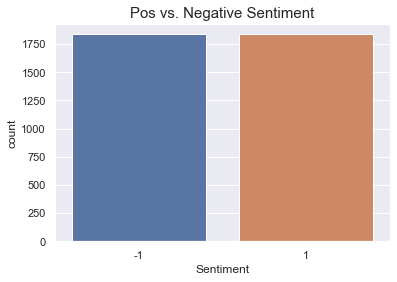

In [23]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df_upsampled)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

In [24]:
print(df_upsampled)

                                                   Text  Sentiment
1617  Nice try Mr.Belfort. Shill your shit stock som...         -1
2373             Stocks go up...but stocks go down too.         -1
4396   So glad I sold my SKLZ shares yesterdayâ¦. ð¤¡          1
7920                               how is it going now?         -1
4204  OTM options are incredibly cheap. $14 calls fo...         -1
...                                                 ...        ...
29                               Thanks for sharing bro         -1
137   As an ape who jumped on the bandwagon a few mo...          1
5295                                          [removed]         -1
6684                                          [removed]          1
5500  Theyâll still be trading during their classe...          1

[3674 rows x 2 columns]


 We begin by compiling a feature list of words from our positive and negative comments to begin to see trends in which words fall into which category generally.

We begin by building a frequency distribution of words in our comments. We can also use this to build our vocab.

In [25]:
# TASK CELL
def word_counter(comments, sentiment):
    '''
    Params:
        comments: a list of comments
        sentiment: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output_occurence: a dictionary mapping each pair to its frequency
    '''

    output_occurence = {}
    vocab = []


    for label, comment in zip(sentiment, comments):
        for word in clean_comment(comment):
            vocab.append(word)
            composite_key = (word, label)
            keys = output_occurence.keys()
            if composite_key in keys:
                output_occurence[composite_key] += 1
            else:
                output_occurence[composite_key] = 1

    vocab = set(vocab)
    
    return output_occurence, vocab

In [26]:
#random.shuffle(documents)
#print(documents[0])
vocab = []
comments = []
sentiments = []
documents = []

for comment in df_upsampled['Text']:
    comments.append(clean_comment(comment))

for sentiment in df_upsampled['Sentiment']:
    sentiments.append(sentiment)

for i in range(len(comments)):
    documents.append((comments[i], sentiments[i]))

random.shuffle(documents)

for comment in comments:
    for word in comment:
        vocab.append(word)

vocab = nltk.FreqDist(vocab)

vocab_features = list(vocab.keys())

print(documents[0][0])


['much', 'pay', 'subtract', 'strike', 'price', 'get', 'breakeven', 'point', 'expirationlook', 'vega', 'option', 'chain', 'look', 'histor', 'volatil', 'prior', 'earn', 'event', 'see', 'much', 'volatil', 'drop', 'multipli', 'percentag', 'point', 'drop', 'vega', 'get', 'approxim', 'amount', 'valu', 'put', 'lost', 'due', 'iv', 'crush']


In [27]:
#Pickles documents for faster use later on
save_documents = open("pickled_outputs/documents.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()

#Pickles the features for faster use later on
save_vocab_features = open("pickled_outputs/vocab_features.pickle","wb")
pickle.dump(vocab_features, save_vocab_features)
save_vocab_features.close()

Now, we categorize each word as positive or negative. We build a function that finds words in our comments and gets their most frequent classification from the dictionary created in find_occurence.

In [28]:
def find_features(comment):
    '''
    Params:
        document: our comment and sentiment
    Return:
        the features, a dictionary of words in the comment mapped to sentiment
    '''
    words = comment
    features = {}

    for w in vocab_features:
        features[w] = (w in words)

    return features

In [29]:
featuresets = [(find_features(comment), sentiment) for (comment, sentiment) in documents]

print(featuresets[1])

({'nice': False, 'tri': False, 'mrbelfort': False, 'shill': False, 'shit': False, 'stock': False, 'somewher': False, 'els': False, 'go': True, 'upbut': False, 'glad': False, 'sold': False, 'sklz': False, 'share': False, 'yesterday': False, 'otm': False, 'option': False, 'incred': False, 'cheap': False, 'call': False, 'next': False, 'friday': False, 'contract': False, 'buy': False, 'youll': False, 'itm': False, 'day': False, 'two': False, 'made': False, 'run': False, 'past': False, 'month': False, 'think': False, 'mean': False, 'mr': False, 'fartadel': False, 'rightbeep': False, 'boop': False, 'im': False, 'realli': False, 'clever': False, 'inexplic': False, 'popular': False, 'bot': False, 'show': False, 'us': False, 'touch': False, 'sorri': False, 'break': False, 'heart': False, 'market': False, 'top': False, 'everyon': False, 'greedi': False, 'fuck': False, 'way': False, 'around': False, 'good': False, 'writeup': False, 'look': True, 'chart': False, 'know': False, 'isnt': False, 'obvi

In [30]:
#Pickle featureset for later use
save_featuresets = open("pickled_outputs/featuresets.pickle","wb")
pickle.dump(featuresets, save_featuresets)
save_featuresets.close()

Let us see how this works on our training data.

In [31]:
cutoff = round(len(featuresets) * 0.8)
training_set = featuresets[:cutoff]
testing_set = featuresets[cutoff+1:]

naive_bayes_classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(naive_bayes_classifier, testing_set))*100)


Classifier accuracy percent: 63.89645776566758


We can see our most influential words below.

In [32]:
naive_bayes_classifier.show_most_informative_features(15)

Most Informative Features
                    best = True                1 : -1     =      9.1 : 1.0
                 current = True                1 : -1     =      8.4 : 1.0
                 absolut = True                1 : -1     =      7.7 : 1.0
                 congrat = True               -1 : 1      =      6.9 : 1.0
                  messag = True                1 : -1     =      6.4 : 1.0
            gainlossyolo = True                1 : -1     =      6.2 : 1.0
                     goe = True                1 : -1     =      5.8 : 1.0
                  someth = True                1 : -1     =      5.8 : 1.0
                    jack = True               -1 : 1      =      5.8 : 1.0
                   bring = True               -1 : 1      =      5.6 : 1.0
                    fine = True               -1 : 1      =      5.6 : 1.0
                      pm = True               -1 : 1      =      5.6 : 1.0
                  whatev = True               -1 : 1      =      5.6 : 1.0

Excellent, we have an accuracy of 82%! Now, we should save this classifier to use when voting later.

In [33]:
save_classifier = open('pickled_outputs/naivebayes.pickle','wb')
pickle.dump(naive_bayes_classifier, save_classifier)
save_classifier.close()

Other classifiers - this may take a substantial amount of time to run.

In [34]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)

BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)

<SklearnClassifier(NuSVC())>

In [35]:
#MNB
save_classifier = open("pickled_outputs/MNB_classifier.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()

#BNB
save_classifier = open("pickled_outputs/BNB_classifier.pickle","wb")
pickle.dump(BNB_classifier, save_classifier)
save_classifier.close()

#Logistic Regression
save_classifier = open("pickled_outputs/LogisticRegression_classifier.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()

#SGD
save_classifier = open("pickled_outputs/SGDClassifier_classifier.pickle","wb")
pickle.dump(SGDClassifier_classifier, save_classifier)
save_classifier.close()

#SVC
save_classifier = open("pickled_outputs/SVC_classifier.pickle","wb")
pickle.dump(SVC_classifier, save_classifier)
save_classifier.close()

#LinearSVC
save_classifier = open("pickled_outputs/LinearSVC_classifier.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()

#NUSVC
save_classifier = open("pickled_outputs/NuSVC_classifier.pickle","wb")
pickle.dump(NuSVC_classifier, save_classifier)
save_classifier.close()


Let's check the accuracy of the above models.

In [36]:
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)
print("BNB accuracy percent:", (nltk.classify.accuracy(BNB_classifier, testing_set))*100)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


MNB_classifier accuracy percent: 62.67029972752044
BNB accuracy percent: 62.125340599455036
LogisticRegression_classifier accuracy percent: 69.34604904632153
SGDClassifier_classifier accuracy percent: 68.66485013623979
SVC_classifier accuracy percent: 73.56948228882834
LinearSVC_classifier accuracy percent: 71.2534059945504
NuSVC_classifier accuracy percent: 76.43051771117166


Declaration of our vote classifier class

In [37]:
class VotingClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for classifier in self._classifiers:
            vote = classifier.classify(features)
            votes.append(vote)
        return mode(votes)

    def evaluate_confidence(self, features):
        votes = []
        for classifier in self._classifiers:
            vote = classifier.classify(features)
            votes.append(vote)
            
        choice_votes = votes.count(mode(votes))
        confidence = choice_votes / len(votes)
        return confidence




In [38]:
voting_classifier = VotingClassifier(naive_bayes_classifier, MNB_classifier, BNB_classifier, LogisticRegression_classifier, SGDClassifier_classifier, SVC_classifier, LinearSVC_classifier, NuSVC_classifier)
print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voting_classifier, testing_set))*100)


voted_classifier accuracy percent: 70.02724795640327


In [39]:
num_to_test = 10

for i in range(num_to_test):
    print("Classification is: ", (voting_classifier.classify(testing_set[i][0])), "Confidence is: ", (voting_classifier.evaluate_confidence(testing_set[i][0]))*100)



Classification is:  -1 Confidence is:  87.5
Classification is:  -1 Confidence is:  87.5
Classification is:  -1 Confidence is:  50.0
Classification is:  -1 Confidence is:  100.0
Classification is:  1 Confidence is:  62.5
Classification is:  -1 Confidence is:  50.0
Classification is:  1 Confidence is:  75.0
Classification is:  -1 Confidence is:  87.5
Classification is:  -1 Confidence is:  75.0
Classification is:  1 Confidence is:  100.0
